In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import plot_df, plot_columns
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
multiplier = 50
min_tick = 0.25
time_int = 60 # time in minutes to build volume candles on
atr_periods = 80

In [3]:
contract = contract.loc['20180102':]
contract

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-01-02 00:00:00,2675.25,2677.00,2674.50,2676.75,2939,2675.700,491
2018-01-02 00:01:00,2676.75,2678.00,2676.50,2678.00,1258,2677.450,206
2018-01-02 00:02:00,2678.00,2678.75,2677.50,2678.50,852,2678.200,119
2018-01-02 00:03:00,2678.50,2678.75,2678.00,2678.25,547,2678.300,99
2018-01-02 00:04:00,2678.25,2678.50,2678.00,2678.50,275,2678.200,66
...,...,...,...,...,...,...,...
2019-09-05 08:51:00,2957.50,2957.75,2957.50,2957.50,361,2957.525,70
2019-09-05 08:52:00,2957.50,2958.00,2957.00,2957.25,517,2957.575,112
2019-09-05 08:53:00,2957.50,2957.75,2957.25,2957.50,267,2957.400,85


In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

63604.29326641914

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-01-02 09:53:00,2675.25,2681.75,2674.50,2678.00,11547,63485,7.250000
1,2018-01-02 14:02:00,2678.00,2684.75,2675.25,2684.00,10473,63689,8.389062
2,2018-01-02 15:29:00,2684.00,2688.25,2683.25,2687.00,6455,52664,7.231017
3,2018-01-02 15:39:00,2687.00,2687.25,2681.75,2685.75,7997,82174,6.781901
4,2018-01-02 15:58:00,2685.75,2687.00,2683.50,2686.50,6720,67696,6.092297
...,...,...,...,...,...,...,...,...
9500,2019-09-04 21:59:00,2938.25,2938.75,2936.75,2938.25,5087,59743,7.924526
9501,2019-09-05 02:38:00,2938.25,2945.25,2936.50,2943.50,13944,81663,7.944908
9502,2019-09-05 03:52:00,2943.75,2964.50,2941.50,2964.25,16532,62567,8.316639


In [6]:
periods = [5, 10, 20, 40, 80, 160, 320]

max mean: 1.5868351577026978
min mean: -3.996820071571414


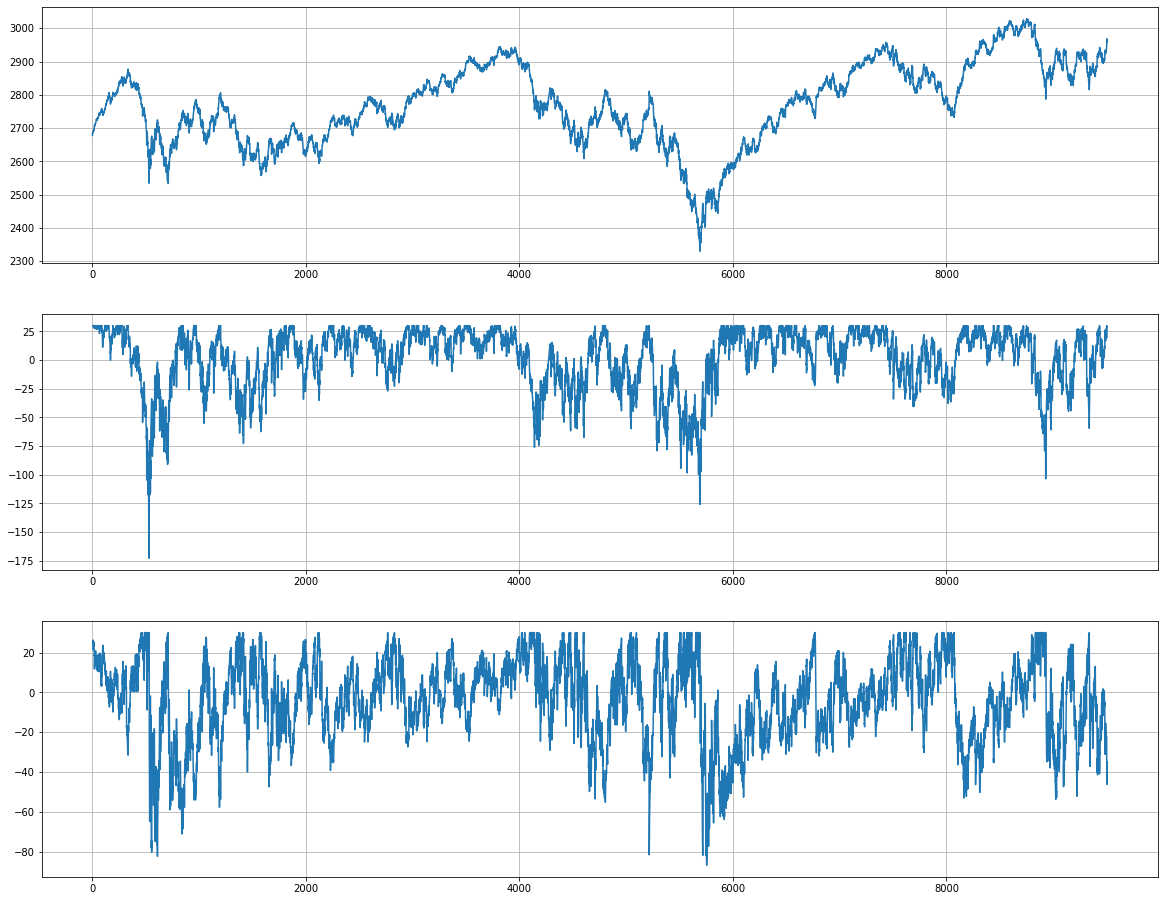

In [7]:
max_candles = pd.DataFrame()
min_candles = pd.DataFrame()
for period in periods:
    max_candles[period] = (vol_candles.close - vol_candles.close.rolling(period).max())
    min_candles[period] = -(vol_candles.close - vol_candles.close.rolling(period).min())
max_candles['total_max'] = max_candles.mean(axis=1) + 30
min_candles['total_min'] = min_candles.mean(axis=1) + 30
print(f"max mean: {max_candles['total_max'].mean()}") 
print(f"min mean: {min_candles['total_min'].mean()}")
plot_columns(vol_candles['close'], max_candles['total_max'], min_candles['total_min'])

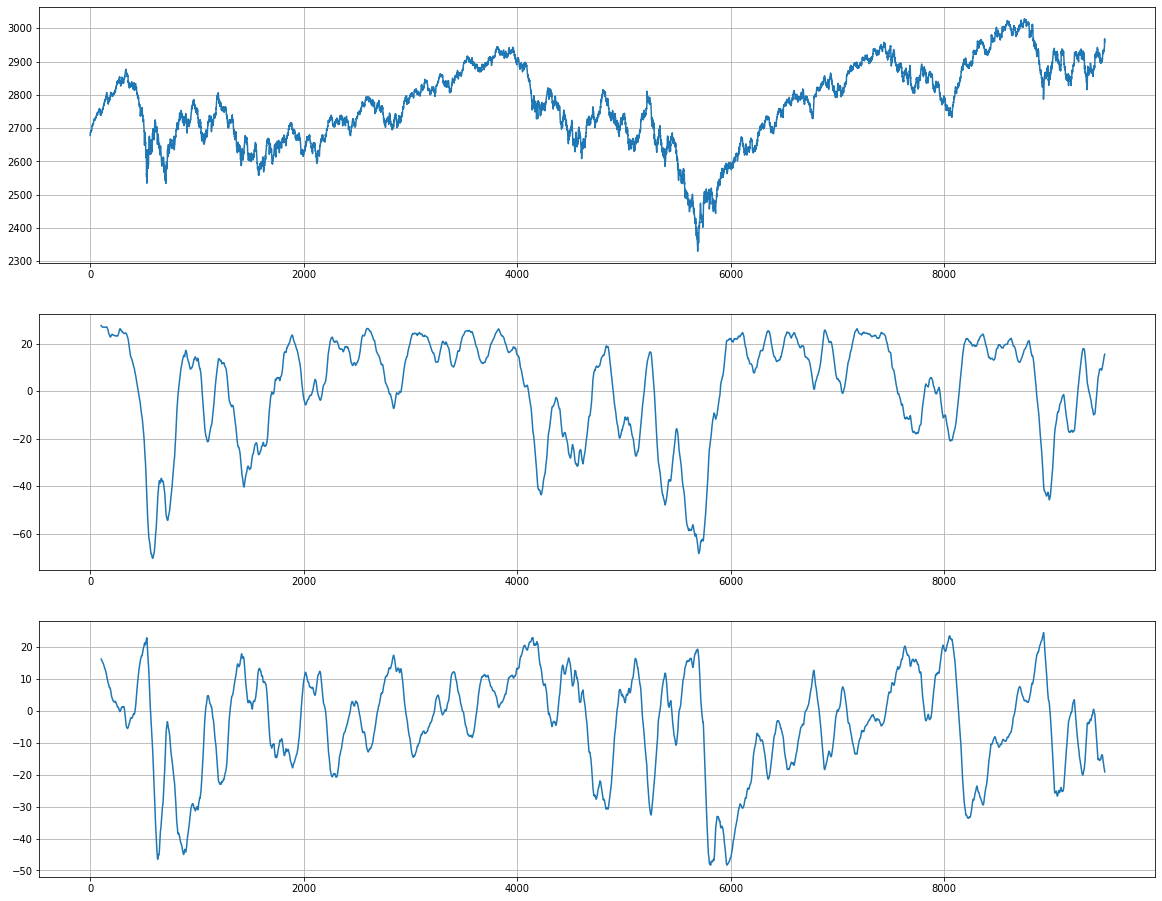

In [8]:
max_candles['total_max'] = max_candles['total_max'].rolling(100).mean() 
min_candles['total_min'] = min_candles['total_min'].rolling(100).mean() 
plot_columns(vol_candles['close'], max_candles['total_max'], min_candles['total_min'])

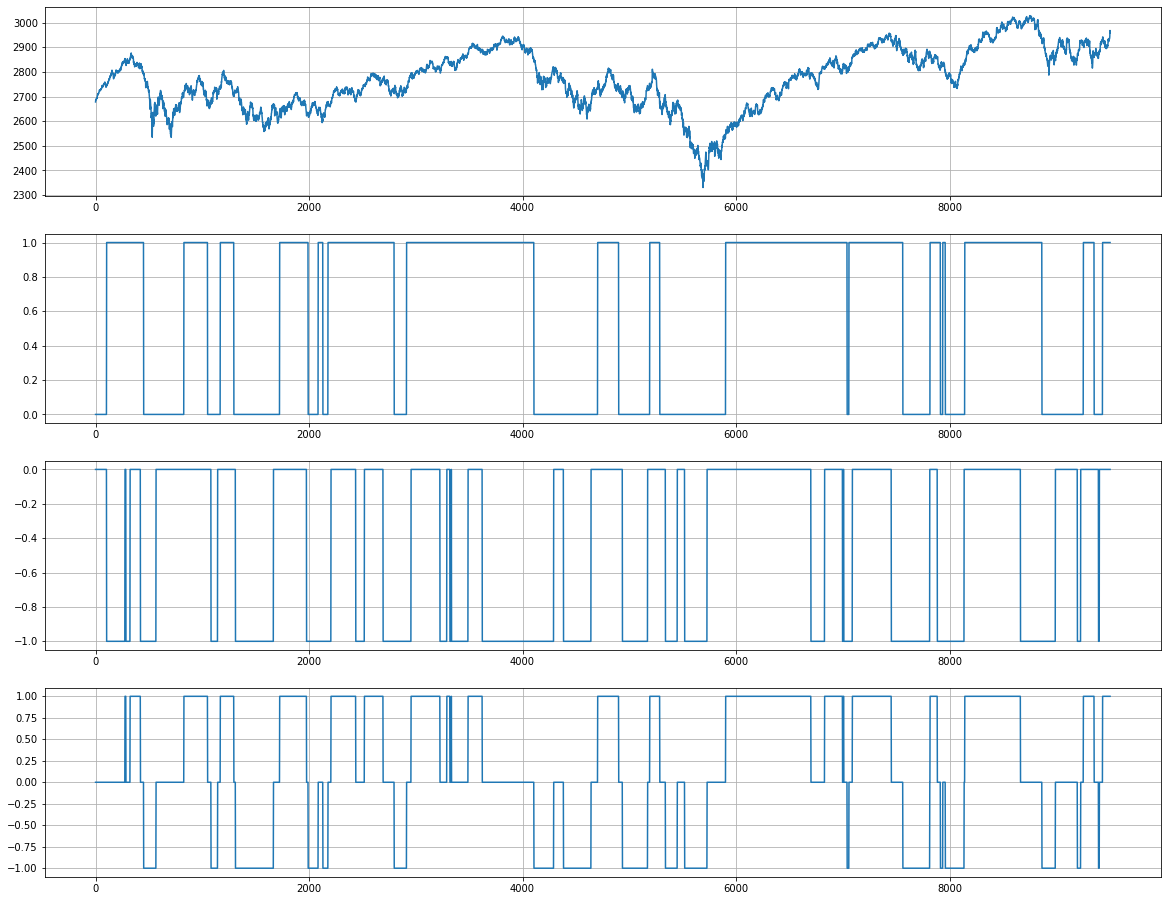

In [9]:
max_candles['total_max'] = (max_candles['total_max'] > 0) * 1
min_candles['total_min'] = (min_candles['total_min'] > 0) *-1
#max_candles['total_max'] = max_candles['total_max'] + max_candles['total_max'].shift(1)
#min_candles['total_min'] = min_candles['total_min'] + min_candles['total_min'].shift(1)
total = max_candles['total_max'] + min_candles['total_min']
plot_columns(vol_candles['close'], max_candles['total_max'], min_candles['total_min'], total)

In [10]:
max_num = (total[total>0]).count()
min_num = (total[total<0]).count()
max_num, min_num, total.count()

(3940, 2424, 9505)

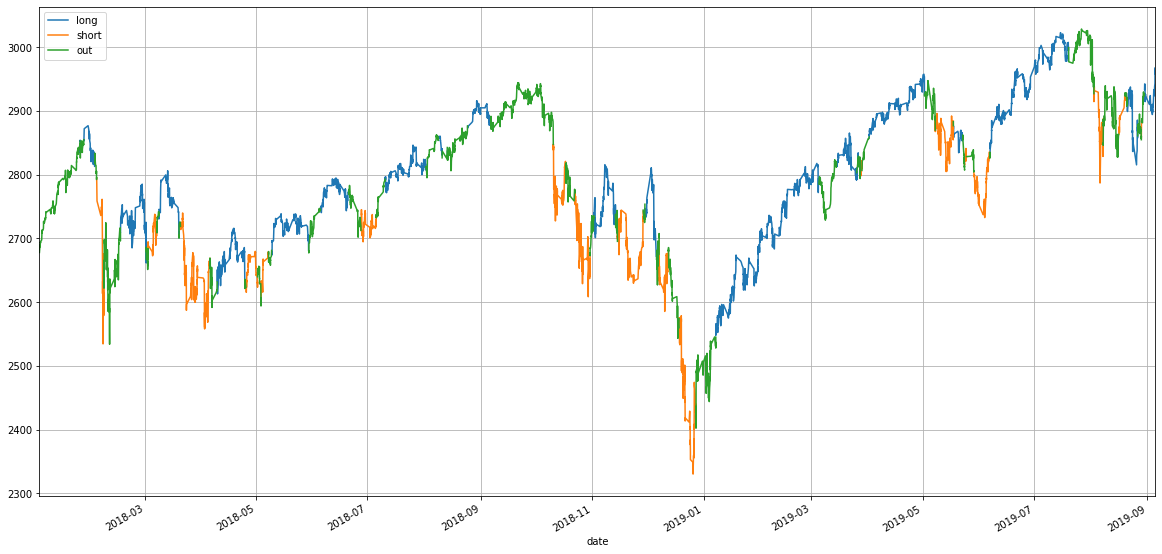

In [11]:
positions = pd.DataFrame({'date': vol_candles['date'],
                            'close': vol_candles['close'],
                         'total': total})
positions['long'] = (positions.total > 0) * positions.close
positions['short'] = (positions.total < 0) * positions.close
positions['out'] = (positions.total == 0) * positions.close
positions.set_index('date', inplace=True)
positions[['long', 'short', 'out']].replace(0, np.nan).plot(figsize=(20,10), grid=True);

In [12]:
vol_candles.tail()

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
9500,2019-09-04 21:59:00,2938.25,2938.75,2936.75,2938.25,5087,59743,7.924526
9501,2019-09-05 02:38:00,2938.25,2945.25,2936.50,2943.50,13944,81663,7.944908
9502,2019-09-05 03:52:00,2943.75,2964.50,2941.50,2964.25,16532,62567,8.316639
9503,2019-09-05 07:17:00,2964.25,2971.75,2963.25,2968.25,15945,65762,8.321166
9504,2019-09-05 08:55:00,2968.25,2970.75,2957.00,2958.00,9666,42561,8.455212


In [13]:
indicators = pd.DataFrame({'close': vol_candles.close,
                          'atr': vol_candles.atr})


In [14]:
roc_periods = [1, 3, 5, 7]

In [15]:
for period in roc_periods:
    indicators[f'roc_{period}'] = (indicators.close.shift(period)/indicators.close - 1) * 1000
cols = [f'roc_{period}' for period in periods]
indicators['avg_roc'] = indicators[indicators.columns[2:]].mean(axis=1)

In [16]:
indicators['roc_ema'] = indicators.avg_roc.ewm(span=200).mean().abs()
indicators['diff'] = indicators.avg_roc - indicators.roc_ema
indicators['std'] = indicators.roc_ema.expanding().std()
indicators['upper'] = indicators.roc_ema.expanding().mean() + indicators['std'] * 2
indicators['lower'] = indicators.roc_ema.expanding().mean() - indicators['std'] * 2
indicators['upper_filter'] = (indicators['upper'] < indicators['roc_ema']) * 1
indicators['lower_filter'] = (indicators['lower'] > indicators['roc_ema']) * 1
indicators

,close,atr,roc_1,roc_3,roc_5,roc_7,avg_roc,roc_ema,diff,std,upper,lower,upper_filter,lower_filter
label,,,,,,,,,,,,,,
0,2678.00,7.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2684.00,8.389062,-2.235469,NaN,NaN,NaN,-2.235469,2.235469,-4.470939,NaN,NaN,NaN,0,0
2,2687.00,7.231017,-1.116487,NaN,NaN,NaN,-1.116487,1.673181,-2.789667,0.397598,2.749521,1.159129,0,0
3,2685.75,6.781901,0.465419,-2.885600,NaN,NaN,-1.210090,1.517271,-2.727361,0.377775,2.564191,1.053090,0,0
4,2686.50,6.092297,-0.279174,-0.930579,NaN,NaN,-0.604876,1.285739,-1.890616,0.404350,2.486616,0.869215,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9500,2938.25,7.924526,0.000000,-1.446439,-1.446439,-3.658640,-1.637880,0.439040,-2.076920,0.358065,1.187272,-0.244990,0,0
9501,2943.50,7.944908,-1.783591,-2.123323,-4.416511,-3.567182,-2.972652,0.464250,-3.436902,0.358047,1.187233,-0.244953,0,0
9502,2964.25,8.316639,-7.000084,-8.771190,-10.204942,-10.204942,-9.045290,0.549634,-9.594923,0.358029,1.187206,-0.244909,0,0


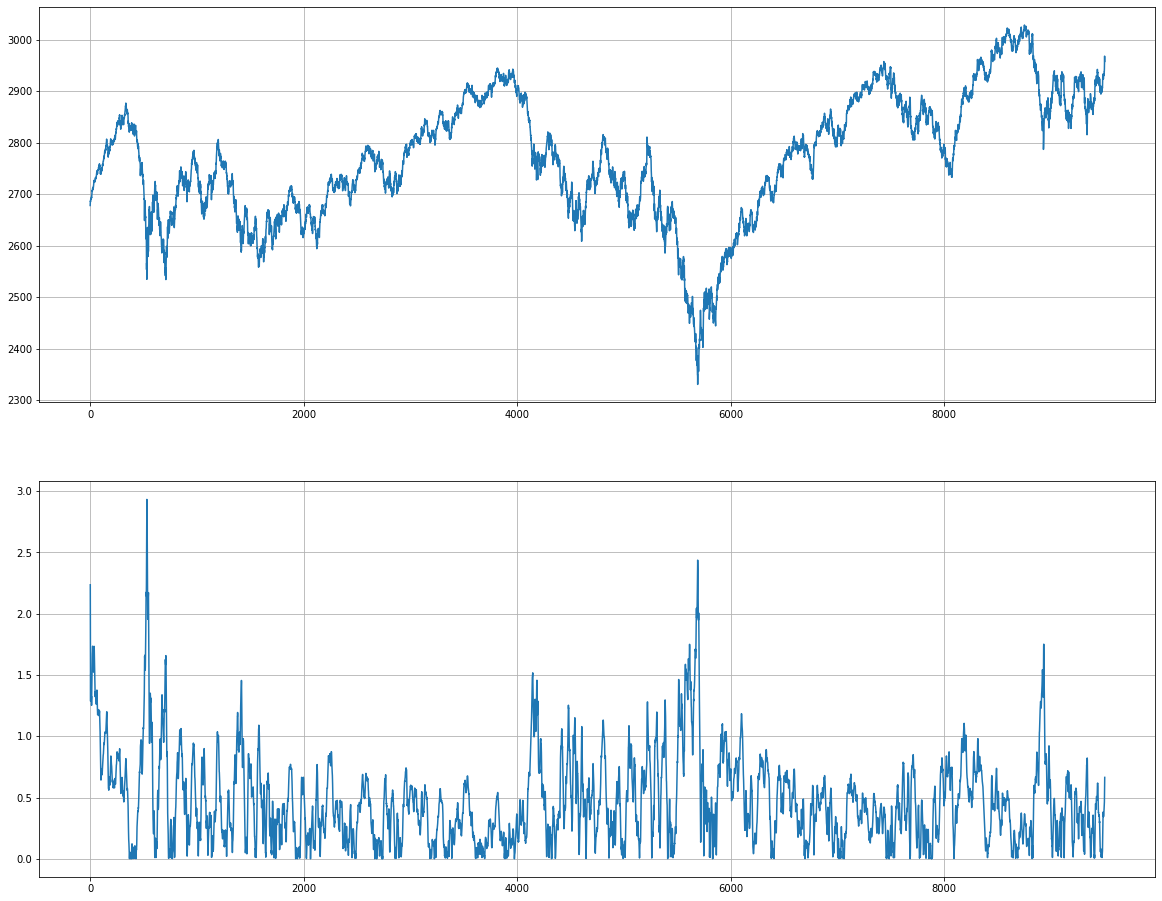

In [17]:
plot_df(indicators[['close','roc_ema']])